# Analisis Pengaruh Tingkat Pendidikan terhadap Tingkat Pengangguran di Indonesia

## Business Understanding
Tujuan dari proyek ini adalah untuk memahami pengaruh rata-rata tingkat pendidikan terhadap tingkat pengangguran di berbagai provinsi di Indonesia.

Dengan menggunakan metode **K-Means Clustering**, kita dapat mengelompokkan provinsi berdasarkan karakteristik pendidikan dan penganggurannya. Selain itu, dengan **Decision Tree** dan **Regresi Linear**, kita dapat membangun model prediksi dan mengukur kekuatan hubungan linear antar variabel.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('dataset_tubes.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_tubes.csv'

## Exploratory Data Analysis

In [ ]:

# Asumsi lama tahun pendidikan
tahun_pendidikan = {
    'Tidak/belum pernah sekolah': 0,
    'Tidak/belum tamat SD': 3,
    'SD': 6,
    'SLTP': 9,
    'SLTA Umum/SMU': 12,
    'SLTA Kejuruan/SMK': 12,
    'Akademi/Diploma': 14,
    'Universitas': 16
}

# Hitung total populasi berpendidikan dan jumlah tahun total
df['Total_Pendidikan_Terpenuhi'] = (
    df['Tidak/belum pernah sekolah'] * tahun_pendidikan['Tidak/belum pernah sekolah'] +
    df['Tidak/belum tamat SD'] * tahun_pendidikan['Tidak/belum tamat SD'] +
    df['SD'] * tahun_pendidikan['SD'] +
    df['SLTP'] * tahun_pendidikan['SLTP'] +
    df['SLTA Umum/SMU'] * tahun_pendidikan['SLTA Umum/SMU'] +
    df['SLTA Kejuruan/SMK'] * tahun_pendidikan['SLTA Kejuruan/SMK'] +
    df['Akademi/Diploma'] * tahun_pendidikan['Akademi/Diploma'] +
    df['Universitas'] * tahun_pendidikan['Universitas']
)

df['Pendidikan_RataRata'] = df['Total_Pendidikan_Terpenuhi'] / df['Total']
df.head()

,Periode,Bulan,Tidak/belum pernah sekolah,Tidak/belum tamat SD,SD,SLTP,SLTA Umum/SMU,SLTA Kejuruan/SMK,Akademi/Diploma,Universitas,Total,Total_Pendidikan_Terpenuhi,Pendidikan_RataRata
0,2006,Februari,234465,614960,2675459,2860007,2842876,1204140,297185,375601,11104693,102372095,9.218814
1,2006,Agustus,170666,611254,2589699,2730045,2851518,1305190,278074,395554,10932000,102044757,9.334500
2,2007,Februari,145750,520316,2753548,2643062,2630360,1114675,330316,409890,10547917,97992878,9.290259
3,2007,Agustus,94301,438519,2179792,2264198,2532204,1538349,397191,566588,10011142,98244809,9.813547
4,2008,Februari,79764,448431,2216748,2166619,2204377,1165582,519867,626202,9427590,91882230,9.746099


In [ ]:

# Simulasi: semakin tinggi rata-rata pendidikan, semakin rendah tingkat pengangguran
np.random.seed(42)
df['Tingkat_Pengangguran'] = 12 * np.exp(-0.2 * df['Pendidikan_RataRata']) + np.random.normal(0, 0.3, size=len(df))
df['Tingkat_Pengangguran'] = df['Tingkat_Pengangguran'].clip(lower=1)  # minimal 1%
df[['Periode', 'Pendidikan_RataRata', 'Tingkat_Pengangguran']].head()

,Periode,Pendidikan_RataRata,Tingkat_Pengangguran
0,2006,9.218814,2.047666
1,2006,9.334500,1.813747
2,2007,9.290259,2.066021
3,2007,9.813547,2.142637
4,2008,9.746099,1.638375


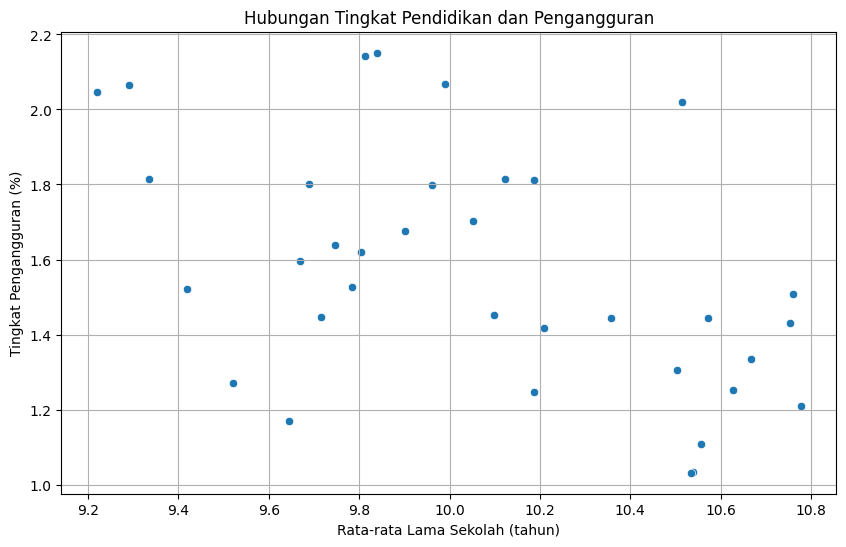

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Pendidikan_RataRata', y='Tingkat_Pengangguran', data=df)
plt.title('Hubungan Tingkat Pendidikan dan Pengangguran')
plt.xlabel('Rata-rata Lama Sekolah (tahun)')
plt.ylabel('Tingkat Pengangguran (%)')
plt.grid(True)
plt.show()

## K-Means Clustering

In [ ]:
def find_outlier_boundary(df, variable):


    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

In [ ]:
full_occup_upper_limit, full_occup_lower_limit = find_outlier_boundary(df,'Universitas')
full_occup_upper_limit, full_occup_lower_limit

(np.float64(1036088.5), np.float64(255484.5))

In [ ]:
full_occup_upper_limit, full_occup_lower_limit = find_outlier_boundary(df,'Tidak/belum pernah sekolah')
full_occup_upper_limit, full_occup_lower_limit

(np.float64(211656.5), np.float64(-65239.5))

In [ ]:
data_clf = df[(df['Tidak/belum pernah sekolah'] <= full_occup_upper_limit) & (df['Tidak/belum pernah sekolah'] >= full_occup_lower_limit)]

In [ ]:
data_clf = df[(df['Tidak/belum pernah sekolah'] <= full_occup_upper_limit) & (df['Universitas'] >= full_occup_lower_limit)]

In [ ]:
print(data_clf.columns.tolist())



['Periode', 'Bulan', 'Tidak/belum pernah sekolah', 'Tidak/belum tamat SD', 'SD', 'SLTP', 'SLTA Umum/SMU', 'SLTA Kejuruan/SMK', 'Akademi/Diploma', 'Universitas', 'Total', 'Total_Pendidikan_Terpenuhi', 'Pendidikan_RataRata', 'Tingkat_Pengangguran']


In [ ]:
data_clf.head()

,Periode,Bulan,Tidak/belum pernah sekolah,Tidak/belum tamat SD,SD,SLTP,SLTA Umum/SMU,SLTA Kejuruan/SMK,Akademi/Diploma,Universitas,Total,Total_Pendidikan_Terpenuhi,Pendidikan_RataRata,Tingkat_Pengangguran
1,2006,Agustus,170666,611254,2589699,2730045,2851518,1305190,278074,395554,10932000,102044757,9.334500,1.813747
2,2007,Februari,145750,520316,2753548,2643062,2630360,1114675,330316,409890,10547917,97992878,9.290259,2.066021
3,2007,Agustus,94301,438519,2179792,2264198,2532204,1538349,397191,566588,10011142,98244809,9.813547,2.142637
4,2008,Februari,79764,448431,2216748,2166619,2204377,1165582,519867,626202,9427590,91882230,9.746099,1.638375
5,2008,Agustus,103206,443832,2099968,1973986,2403394,1409128,362683,598318,9394515,92098092,9.803390,1.618914


In [ ]:
# Ubah nama kolom jika perlu
data_clf.rename(columns=lambda x: x.strip(), inplace=True)

# Bersihkan nilai NaN dan spasi
data_clf['Universitas'] = data_clf['Universitas'].astype(str).str.strip()
data_clf = data_clf[data_clf['Universitas'].notnull()]
data_clf = data_clf[data_clf['Universitas'] != '']

In [ ]:


def check_plot(data, column_name):
    # Bersihkan kolom yang akan digunakan
    data[column_name] = data[column_name].astype(str).str.strip()
    data = data[data[column_name].notnull()]
    data = data[data[column_name] != '']

    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=column_name, order=data[column_name].value_counts().index)
    plt.title(f'Count Plot of {column_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


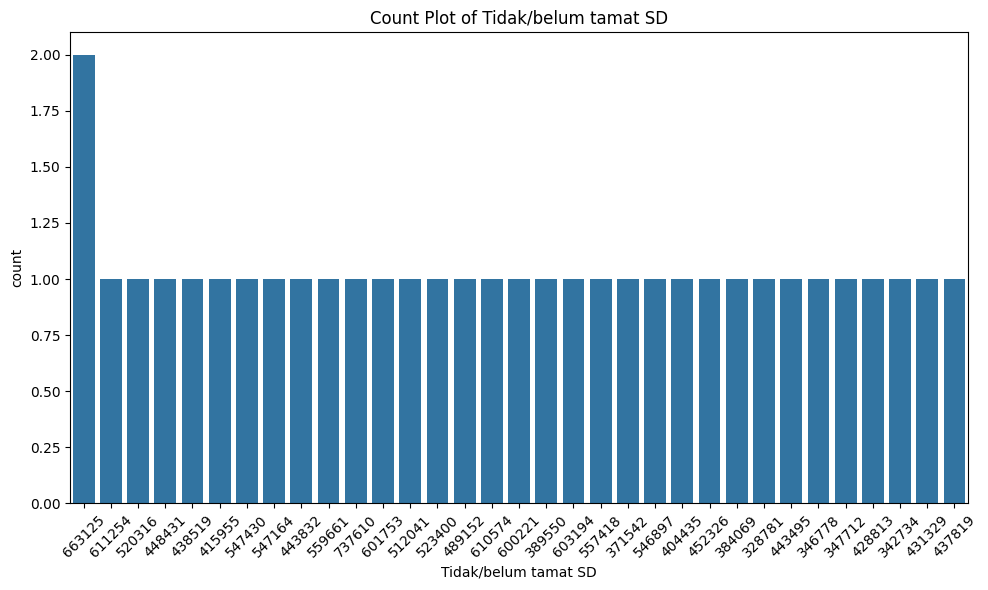

In [ ]:
check_plot(data_clf, 'Tidak/belum tamat SD')

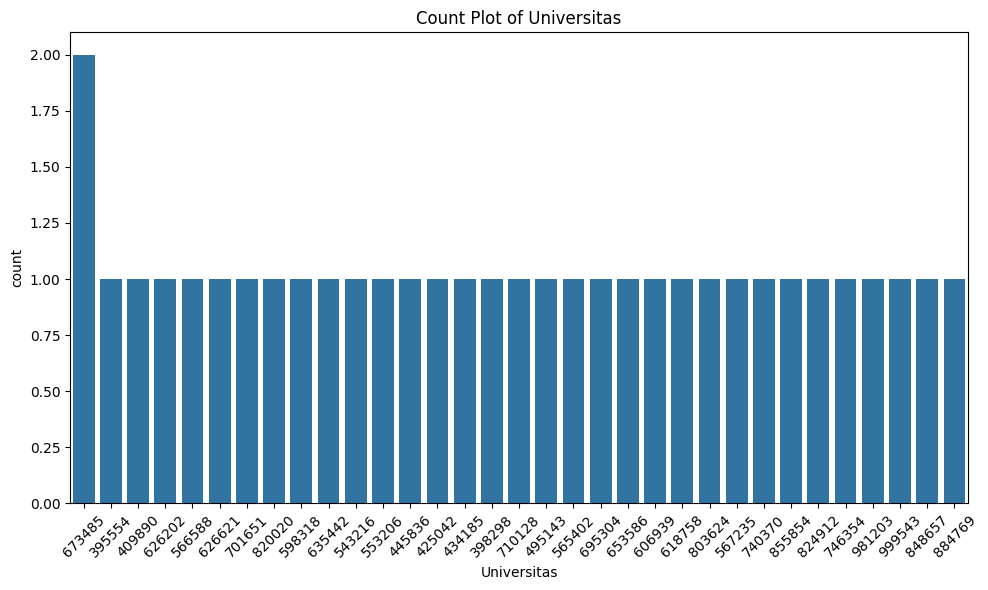

In [ ]:
check_plot(data_clf, 'Universitas')

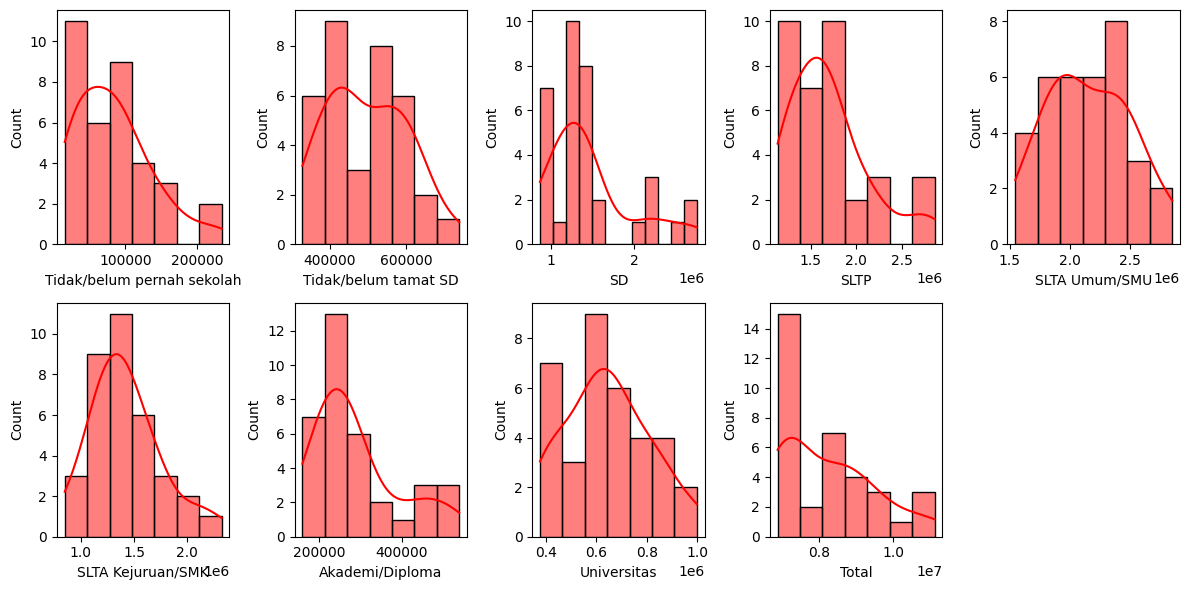

In [ ]:
plt.figure(figsize=(12,6))

# Define the list of numerical features you want to plot
numericals = ['Tidak/belum pernah sekolah', 'Tidak/belum tamat SD', 'SD', 'SLTP', 'SLTA Umum/SMU', 'SLTA Kejuruan/SMK', 'Akademi/Diploma', 'Universitas', 'Total']

features = numericals
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    sns.histplot(x=df[features[i]], color='red', kde=True)
    plt.xlabel(features[i])
    plt.tight_layout()
plt.show()

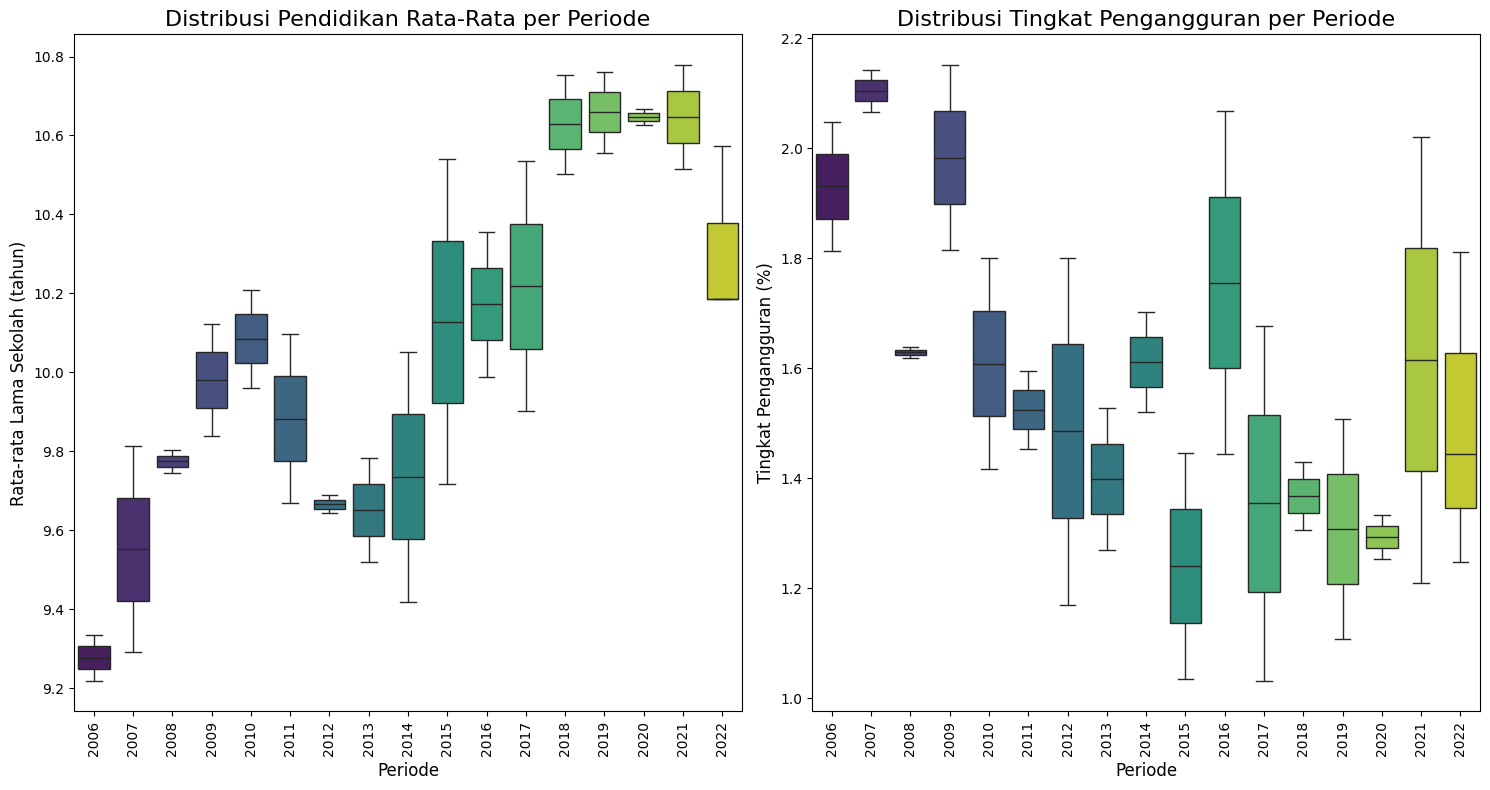

In [ ]:
plt.figure(figsize=(15, 8))

# Box plot untuk Pendidikan Rata-Rata
plt.subplot(1, 2, 1) # 1 baris, 2 kolom, plot ke-1
sns.boxplot(x='Periode', y='Pendidikan_RataRata', data=df, palette='viridis')
plt.title('Distribusi Pendidikan Rata-Rata per Periode', fontsize=16)
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Rata-rata Lama Sekolah (tahun)', fontsize=12)
plt.xticks(rotation=90)
# Anda bisa sesuaikan batas sumbu y jika perlu, contoh: plt.ylim(0, df['Pendidikan_RataRata'].quantile(0.95))

# Box plot untuk Tingkat Pengangguran
plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot ke-2
sns.boxplot(x='Periode', y='Tingkat_Pengangguran', data=df, palette='viridis')
plt.title('Distribusi Tingkat Pengangguran per Periode', fontsize=16)
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Tingkat Pengangguran (%)', fontsize=12)
plt.xticks(rotation=90)
# Anda bisa sesuaikan batas sumbu y jika perlu, contoh: plt.ylim(0, df['Tingkat_Pengangguran'].quantile(0.95))


plt.tight_layout()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Periode                     35 non-null     int64  
 1   Bulan                       35 non-null     object 
 2   Tidak/belum pernah sekolah  35 non-null     int64  
 3   Tidak/belum tamat SD        35 non-null     int64  
 4   SD                          35 non-null     int64  
 5   SLTP                        35 non-null     int64  
 6   SLTA Umum/SMU               35 non-null     int64  
 7   SLTA Kejuruan/SMK           35 non-null     int64  
 8   Akademi/Diploma             35 non-null     int64  
 9   Universitas                 35 non-null     int64  
 10  Total                       35 non-null     int64  
 11  Total_Pendidikan_Terpenuhi  35 non-null     int64  
 12  Pendidikan_RataRata         35 non-null     float64
 13  Tingkat_Pengangguran        35 non-nu

In [ ]:
df_filtered = df[df['Tingkat_Pengangguran'] > df['Tingkat_Pengangguran'].mean()]
df_filtered

,Periode,Bulan,Tidak/belum pernah sekolah,Tidak/belum tamat SD,SD,SLTP,SLTA Umum/SMU,SLTA Kejuruan/SMK,Akademi/Diploma,Universitas,Total,Total_Pendidikan_Terpenuhi,Pendidikan_RataRata,Tingkat_Pengangguran
0,2006,Februari,234465,614960,2675459,2860007,2842876,1204140,297185,375601,11104693,102372095,9.218814,2.047666
1,2006,Agustus,170666,611254,2589699,2730045,2851518,1305190,278074,395554,10932000,102044757,9.334500,1.813747
2,2007,Februari,145750,520316,2753548,2643062,2630360,1114675,330316,409890,10547917,97992878,9.290259,2.066021
3,2007,Agustus,94301,438519,2179792,2264198,2532204,1538349,397191,566588,10011142,98244809,9.813547,2.142637
4,2008,Februari,79764,448431,2216748,2166619,2204377,1165582,519867,626202,9427590,91882230,9.746099,1.638375
5,2008,Agustus,103206,443832,2099968,1973986,2403394,1409128,362683,598318,9394515,92098092,9.803390,1.618914
6,2009,Februari,60347,415955,2143747,2054682,2133627,1337586,486399,626621,9258964,91092563,9.838311,2.151163
7,2009,Agustus,90471,547430,1531671,1770823,2472245,1407226,441100,701651,8962617,90725191,10.122623,1.814910
9,2010,Agustus,157586,600221,1402858,1661449,2149123,1195192,443222,710128,8319779,82869788,9.960576,1.799647
11,2011,Agustus,205388,737610,1241882,2138864,2376254,1161362,276816,543216,8681392,83932170,9.668054,1.595781


In [ ]:
periode_counts = df['Periode'].value_counts().sort_values(ascending=False)
periode_counts

,count
Periode,
2022,3
2006,2
2007,2
2009,2
2008,2
2011,2
2012,2
2013,2
2010,2


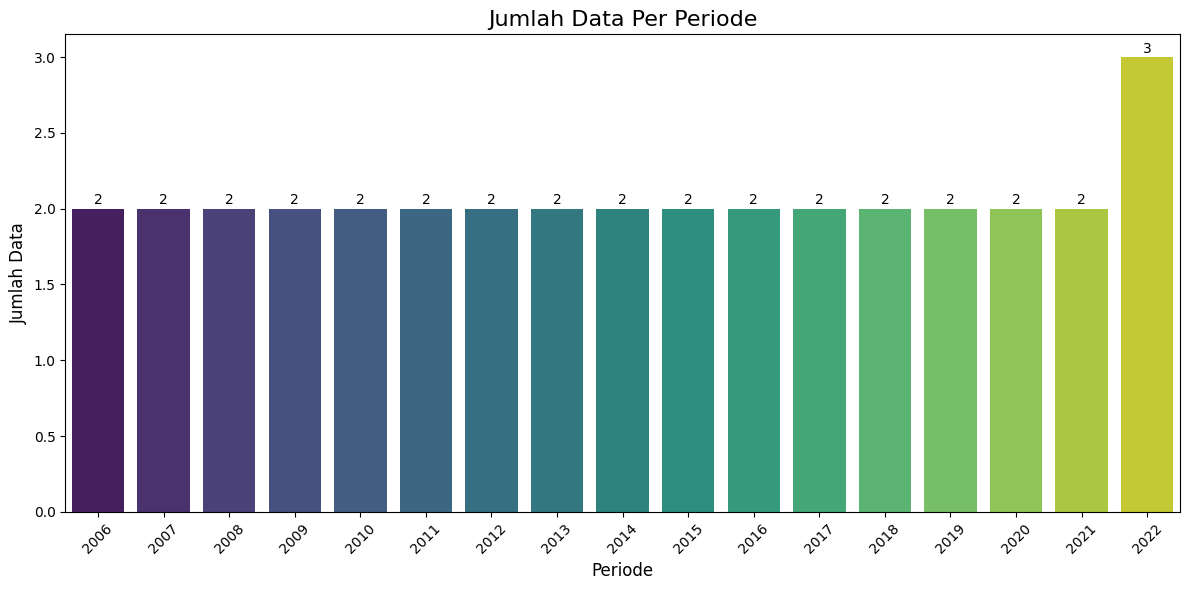

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kolom yang berisi informasi periode quarter
kolom_periode_quarter = 'Periode' # Pastikan ini nama kolom yang benar

# Gunakan hasil perhitungan value_counts() dari kolom periode quarter
if kolom_periode_quarter in df.columns:
    periode_counts_df = df[kolom_periode_quarter].value_counts().reset_index()
    periode_counts_df.columns = [kolom_periode_quarter, 'Jumlah Data'] # Sesuaikan nama kolom

    # Mengurutkan periode (opsional tapi disarankan)
    # Ini mungkin memerlukan penyesuaian tergantung format eksak kolom 'Periode' Anda
    # Misalnya, jika formatnya "YYYY Qx", mengurutkan string mungkin sudah cukup
    periode_counts_df = periode_counts_df.sort_values(by=kolom_periode_quarter)

    plt.figure(figsize=(12, 6)) # Sesuaikan ukuran figure jika perlu
    sns.barplot(x=kolom_periode_quarter, y='Jumlah Data', data=periode_counts_df, palette='viridis')

    # Tambahkan label jumlah di atas bar
    for i, count in enumerate(periode_counts_df['Jumlah Data']):
        plt.text(i, count + (0.01 * periode_counts_df['Jumlah Data'].max()), f"{count:,.0f}",
                 ha='center', fontsize=10, color='black')

    plt.title(f'Jumlah Data Per {kolom_periode_quarter}', fontsize=16) # Judul plot
    plt.xlabel(kolom_periode_quarter, fontsize=12) # Label sumbu X
    plt.ylabel('Jumlah Data', fontsize=12) # Label sumbu Y
    plt.xticks(rotation=45) # Rotasi label sumbu X

    plt.tight_layout()
    plt.show()
else:
    print(f"Kolom '{kolom_periode_quarter}' tidak ditemukan di dataframe.")

In [ ]:
df.columns

Index(['Periode', 'Bulan', 'Tidak/belum pernah sekolah',
       'Tidak/belum tamat SD', 'SD', 'SLTP', 'SLTA Umum/SMU',
       'SLTA Kejuruan/SMK', 'Akademi/Diploma', 'Universitas', 'Total',
       'Total_Pendidikan_Terpenuhi', 'Pendidikan_RataRata',
       'Tingkat_Pengangguran'],
      dtype='object')

In [ ]:
# Example: Calculate average 'Tingkat_Pengangguran' per 'Periode'
avg_unemployment_by_period = df.groupby('Periode')['Tingkat_Pengangguran'].mean().sort_values(ascending=False)
print(avg_unemployment_by_period)

# Example: Calculate average 'Pendidikan_RataRata' per 'Periode'
avg_education_by_period = df.groupby('Periode')['Pendidikan_RataRata'].mean().sort_values(ascending=False)
print(avg_education_by_period)

Periode
2007    2.104329
2009    1.983036
2006    1.930706
2016    1.755895
2008    1.628645
2021    1.615087
2014    1.610994
2010    1.608078
2011    1.524637
2022    1.501074
2012    1.485477
2013    1.398784
2018    1.367595
2017    1.354226
2019    1.307487
2020    1.293204
2015    1.240346
Name: Tingkat_Pengangguran, dtype: float64
Periode
2019    10.658996
2021    10.646640
2020    10.646513
2018    10.628600
2022    10.314769
2017    10.218146
2016    10.172795
2015    10.127818
2010    10.085090
2009     9.980467
2011     9.883004
2008     9.774745
2014     9.735197
2012     9.666161
2013     9.651492
2007     9.551903
2006     9.276657
Name: Pendidikan_RataRata, dtype: float64


In [ ]:
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Periode                     35 non-null     int64  
 1   Bulan                       35 non-null     object 
 2   Tidak/belum pernah sekolah  35 non-null     int64  
 3   Tidak/belum tamat SD        35 non-null     int64  
 4   SD                          35 non-null     int64  
 5   SLTP                        35 non-null     int64  
 6   SLTA Umum/SMU               35 non-null     int64  
 7   SLTA Kejuruan/SMK           35 non-null     int64  
 8   Akademi/Diploma             35 non-null     int64  
 9   Universitas                 35 non-null     int64  
 10  Total                       35 non-null     int64  
 11  Total_Pendidikan_Terpenuhi  35 non-null     int64  
 12  Pendidikan_RataRata         35 non-null     float64
 13  Tingkat_Pengangguran        35 non-nu

(None,
    Periode     Bulan  Tidak/belum pernah sekolah  Tidak/belum tamat SD  \
 0     2006  Februari                      234465                614960   
 1     2006   Agustus                      170666                611254   
 2     2007  Februari                      145750                520316   
 3     2007   Agustus                       94301                438519   
 4     2008  Februari                       79764                448431   
 
         SD     SLTP  SLTA Umum/SMU  SLTA Kejuruan/SMK  Akademi/Diploma  \
 0  2675459  2860007        2842876            1204140           297185   
 1  2589699  2730045        2851518            1305190           278074   
 2  2753548  2643062        2630360            1114675           330316   
 3  2179792  2264198        2532204            1538349           397191   
 4  2216748  2166619        2204377            1165582           519867   
 
    Universitas     Total  Total_Pendidikan_Terpenuhi  Pendidikan_RataRata  \
 0       37

In [ ]:

df.describe()

,Periode,Tidak/belum pernah sekolah,Tidak/belum tamat SD,SD,SLTP,SLTA Umum/SMU,SLTA Kejuruan/SMK,Akademi/Diploma,Universitas,Total,Total_Pendidikan_Terpenuhi,Pendidikan_RataRata,Tingkat_Pengangguran
count,35.000000,35.000000,35.000000,3.500000e+01,3.500000e+01,3.500000e+01,3.500000e+01,35.000000,35.000000,3.500000e+01,3.500000e+01,35.000000,35.000000
mean,2014.228571,83398.457143,496154.714286,1.462738e+06,1.697168e+06,2.153685e+06,1.422718e+06,290182.771429,642869.171429,8.247912e+06,8.280470e+07,10.067221,1.569151
std,5.082182,53949.291460,105794.400661,5.112940e+05,4.367373e+05,3.518458e+05,3.361657e+05,103575.191557,167112.979108,1.233931e+06,1.111764e+07,0.460007,0.321904
min,2006.000000,15206.000000,328781.000000,8.657780e+05,1.137195e+06,1.546699e+06,8.473650e+05,159490.000000,375601.000000,6.898796e+06,6.731635e+07,9.218814,1.031885
25%,2010.000000,38596.500000,422384.000000,1.219224e+06,1.343867e+06,1.902169e+06,1.184779e+06,219345.000000,548211.000000,7.125746e+06,7.282654e+07,9.731253,1.319558
50%,2014.000000,79764.000000,489152.000000,1.320392e+06,1.650387e+06,2.133627e+06,1.383022e+06,254457.000000,626621.000000,8.319779e+06,8.286979e+07,10.051659,1.520384
75%,2018.500000,107820.500000,579941.000000,1.487256e+06,1.828030e+06,2.437820e+06,1.595546e+06,317788.500000,743362.000000,9.032334e+06,9.148740e+07,10.524864,1.806246
max,2022.000000,234465.000000,737610.000000,2.753548e+06,2.860007e+06,2.851518e+06,2.326599e+06,538186.000000,999543.000000,1.110469e+07,1.041847e+08,10.778267,2.151163


In [ ]:

# Kelompokkan data berdasarkan 'Periode' dan hitung rata-rata kolom yang relevan
periode_summary = df.groupby('Periode').agg(
    rata_rata_pendidikan=('Pendidikan_RataRata', 'mean'),
    rata_rata_pengangguran=('Tingkat_Pengangguran', 'mean'),
).reset_index()

# Cetak ringkasan per periode
print(periode_summary)

    Periode  rata_rata_pendidikan  rata_rata_pengangguran
0      2006              9.276657                1.930706
1      2007              9.551903                2.104329
2      2008              9.774745                1.628645
3      2009              9.980467                1.983036
4      2010             10.085090                1.608078
5      2011              9.883004                1.524637
6      2012              9.666161                1.485477
7      2013              9.651492                1.398784
8      2014              9.735197                1.610994
9      2015             10.127818                1.240346
10     2016             10.172795                1.755895
11     2017             10.218146                1.354226
12     2018             10.628600                1.367595
13     2019             10.658996                1.307487
14     2020             10.646513                1.293204
15     2021             10.646640                1.615087
16     2022   

In [ ]:
df['profit'] = df['Tingkat_Pengangguran'] - df['Pendidikan_RataRata']

In [ ]:
# Kelompokkan data berdasarkan 'Periode' dan hitung total 'profit' serta jumlah data per periode
periode_summary = df.groupby('Periode').agg(
    total_profit=('profit', 'sum'),
    jumlah_data=('Periode', 'count')  # Menghitung jumlah baris per periode
).reset_index()

# Cetak ringkasan per periode
print(periode_summary)

    Periode  total_profit  jumlah_data
0      2006    -14.691901            2
1      2007    -14.895148            2
2      2008    -16.292200            2
3      2009    -15.994860            2
4      2010    -16.954024            2
5      2011    -16.716734            2
6      2012    -16.361368            2
7      2013    -16.505416            2
8      2014    -16.248405            2
9      2015    -17.774943            2
10     2016    -16.833800            2
11     2017    -17.727840            2
12     2018    -18.522012            2
13     2019    -18.703018            2
14     2020    -18.706619            2
15     2021    -18.063106            2
16     2022    -26.441084            3


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pickle

In [ ]:
features_for_clustering = ['Pendidikan_RataRata', 'Tingkat_Pengangguran']
X = df[features_for_clustering]

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)

In [ ]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)

    inertias.append(kmeans.inertia_)


    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

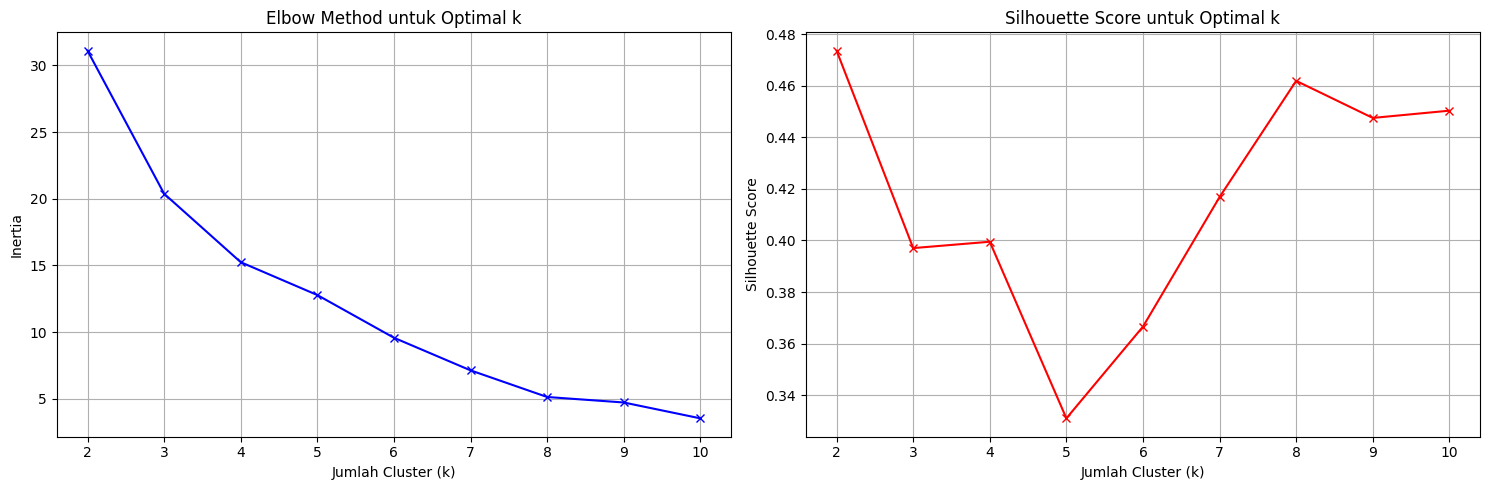


Nilai Silhouette Score untuk setiap k:
k=2: 0.4736
k=3: 0.3970
k=4: 0.3995
k=5: 0.3310
k=6: 0.3666
k=7: 0.4168
k=8: 0.4619
k=9: 0.4475
k=10: 0.4503


In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Optimal k')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'rx-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nNilai Silhouette Score untuk setiap k:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")

In [ ]:
optimal_k = 3
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = final_kmeans.fit_predict(X_scaled)

In [ ]:
cluster_summary = df.groupby('cluster').agg({
    'Pendidikan_RataRata': 'mean',
    'Tingkat_Pengangguran': 'mean',
    'Periode': 'count'
}).round(2)

cluster_summary.rename(columns={'Periode': 'Jumlah Data'}, inplace=True)

print(cluster_summary)


         Pendidikan_RataRata  Tingkat_Pengangguran  Jumlah Data
cluster                                                        
0                       9.71                  1.47            9
1                      10.54                  1.29           13
2                       9.84                  1.92           13


In [ ]:
print("\nRingkasan Cluster:")
print(cluster_summary)


Ringkasan Cluster:
         Pendidikan_RataRata  Tingkat_Pengangguran  Jumlah Data
cluster                                                        
0                       9.71                  1.47            9
1                      10.54                  1.29           13
2                       9.84                  1.92           13


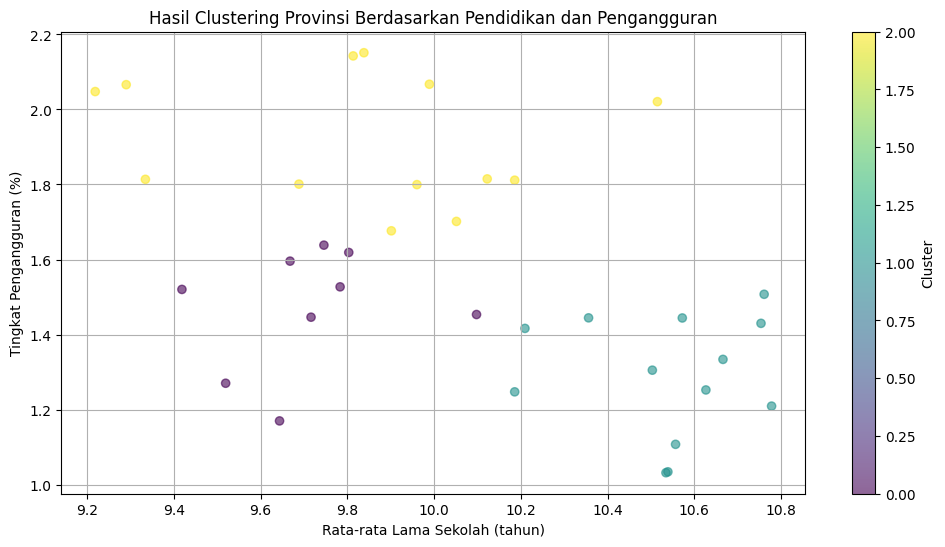

In [ ]:
plt.figure(figsize=(12, 6))

scatter = plt.scatter(df['Pendidikan_RataRata'], df['Tingkat_Pengangguran'],
                     c=df['cluster'],
                     cmap='viridis',
                     alpha=0.6)
plt.xlabel('Rata-rata Lama Sekolah (tahun)')
plt.ylabel('Tingkat Pengangguran (%)')
plt.title('Hasil Clustering Provinsi Berdasarkan Pendidikan dan Pengangguran')

plt.colorbar(scatter, label='Cluster')

plt.grid(True)

plt.show()

## Decision Tree Regression

In [ ]:
X = df[['Pendidikan_RataRata']]
y = df['Tingkat_Pengangguran']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R2 Score (Decision Tree): {r2:.4f}")
print(f"RMSE (Decision Tree): {rmse:.2f}")

In [ ]:
plt.figure(figsize=(15,8))
plot_tree(tree, feature_names=['Pendidikan_RataRata'], filled=True, rounded=True)
plt.title("Decision Tree - Prediksi Pengangguran Berdasarkan Pendidikan")
plt.show()

## Regresi Linear: Pengaruh Pendidikan terhadap Pengangguran

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_linreg_pred = linreg.predict(X_test)

r2_linreg = r2_score(y_test, y_linreg_pred)
rmse_linreg = mean_squared_error(y_test, y_linreg_pred, squared=False)

print(f"R2 Score (Linear Regression): {r2_linreg:.4f}")
print(f"RMSE (Linear Regression): {rmse_linreg:.2f}")

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(X, y, color='blue', label='Data Asli')
plt.plot(X, linreg.predict(X), color='red', linewidth=2, label='Regresi Linear')
plt.xlabel('Rata-rata Lama Sekolah (tahun)')
plt.ylabel('Tingkat Pengangguran (%)')
plt.title('Regresi Linear antara Pendidikan dan Pengangguran')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install pyngrok

In [ ]:
!ngrok config add-authtoken 2wsvRjbCjOiSOWuCLUoF5W6Pvzz_7GRCWdv5Yi6ynKhNzgYff

In [ ]:
import streamlit as st
import pandas as pd

st.title("Analisis Pengaruh Pendidikan terhadap Pengangguran")

uploaded_file = st.file_uploader("Upload dataset CSV", type="csv")
if uploaded_file:
    df = pd.read_csv(uploaded_file)

    # Tambahkan kolom rata-rata pendidikan (simulasi bobot tahunan)
    df['Pendidikan_RataRata'] = (
        df['Tidak/belum pernah sekolah'] * 0 +
        df['Tidak/belum tamat SD'] * 3 +
        df['SD'] * 6 +
        df['SLTP'] * 9 +
        df['SLTA Umum/SMU'] * 12 +
        df['SLTA Kejuruan/SMK'] * 12 +
        df['Akademi/Diploma'] * 14 +
        df['Universitas'] * 16
    ) / df['Total']

    st.subheader("Data dengan Pendidikan Rata-Rata:")
    st.dataframe(df[['Periode', 'Pendidikan_RataRata']].head())

    st.line_chart(df.set_index('Periode')[['Pendidikan_RataRata']])


In [ ]:
!streamlit run app.py


## Kesimpulan
- **K-Means Clustering** mengelompokkan provinsi berdasarkan pola pendidikan dan pengangguran.
- **Decision Tree** menunjukkan struktur pengambilan keputusan yang bisa digunakan untuk prediksi.
- **Regresi Linear** memperlihatkan hubungan linier negatif antara rata-rata pendidikan dan tingkat pengangguran.
- Model ini dapat membantu perumusan kebijakan pendidikan dalam upaya mengurangi pengangguran di Indonesia.